In [1]:
import meep as mp
import numpy as np
from meep import mpb
import matplotlib.pyplot as plt

Using MPI version 3.1, 1 processes


Recall conditions to obtain guided modes for a structure

        
    ncore:         --------

    nclad: --------        ----------
                   <------>
                      d

Transcendental equation for symmetrical mode

$$ u \tan{u} = \sqrt{\left( \frac{V}{2} \right)^2 - u^2} $$

Transcendental equation for antisymmetrical mode

$$ -u \cot{u} = \sqrt{\left( \frac{V}{2} \right)^2 - u^2} $$

with

$$ u = \frac{\left( k_0^2 n_{core}^2 - \beta^2 \right)d}{2} $$

$$ v = \frac{\left(\beta^2 - k_0^2n_{clad}^2 \right)d}{2} $$

$$ V = k_0d\sqrt{n_{core}^2 - n_{clad}^2} $$

$$ k_0^2 = \epsilon_0\mu_0\omega^2 = \frac{\omega^2}{c^2} \rightarrow \omega^2 \text{ in MPB units}$$

Solve for $\beta(\omega)$

In [2]:
def LHS_symm(u):
    return u*np.tan(u)

def RHS(u, V):
    return np.sqrt((V/2)**2 - u**2)

def u(w, ncore, b, d):
    return (w**2*ncore**2 - b**2)*d/2

def v(w, nclad, b, d):
    return (b**2 - w**2*nclad**2)*d/2

def V(w, d, ncore, nclad):
    return w*d*np.sqrt(ncore**2 - nclad**2)

In [3]:
w = 1/1.55
nclad = 1.44
ncore = 1.446789549312546
d = 10.4

V_comp = V(w, d, ncore, nclad)
V_comp

0.9393548387096788

/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


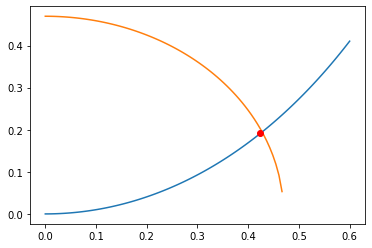

In [4]:
u = np.linspace(0,0.6,100)
plt.plot(u, LHS_symm(u))
plt.plot(u, RHS(u, V_comp))
idx = np.argwhere(np.diff(np.sign(LHS_symm(u) - RHS(u, V_comp)))).flatten()[0]
plt.plot(u[idx], LHS_symm(u[idx]), 'ro')

Use $u$ to solve for $\beta$ by inverting

$$ \beta = \sqrt{k_0^2n_{core}^2 - \frac{2u}{d}} $$

In [48]:
def b(w, ncore, u, d):
    return np.sqrt(w**2*ncore**2 - 2*u/d)

b(w, ncore, u[idx], d)

0.8886360467107857

And so $\beta \approx 0.9$ can be the trial wavevector

In [5]:
# Parameters for the waveguide

# Indices
clad_index = 1.44
core_index = 1.446789549312546

# Materials
clad = mp.Medium(index=clad_index)
core = mp.Medium(index=core_index)

sc = 60  # supercell width (um)
resolution = 100  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(sc))

# define the 2d blocks for the strip and substrate
geometry = [mp.Block(size=mp.Vector3(d),
                     center=mp.Vector3(0), material=core)]

In [6]:
# The k (i.e. beta, i.e. propagation constant) points to look at, in
# units of 2*pi/um.  We'll look at num_k points from k_min to k_max.
num_k = 30
k_min = 0.7
k_max = 1
k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])

# Increase this to see more modes.  (The guided ones are the ones below the
# light line, i.e. those with frequencies < kmag / 1.45, where kmag
# is the corresponding column in the output if you grep for "freqs:".)
num_bands = 4

In [7]:
# ModeSolver object
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    # Add new things pertaining to simulation
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
    dimensions=1,
    default_material=clad
    )

ms.init_params(mp.NO_PARITY, reset_fields=True)

Working in 1 dimensions.
Grid size is 6000 x 1 x 1.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (60, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 60
Reciprocal lattice vectors (/ 2 pi):
     (0.0166667, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (0,0,0)
          size (10.4,0,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...


In [8]:
eps = ms.get_epsilon()

epsilon: 2.0736-2.0932, mean 2.077, harm. mean 2.07697, 100% > 1, 17.3333% "fill"


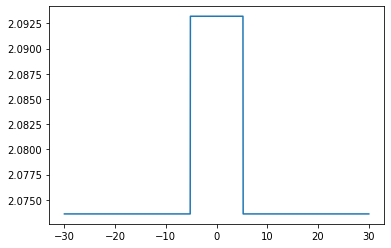

In [9]:
xmin = -sc/2
xmax = sc/2
x = np.linspace(xmin, xmax, resolution*sc)

plt.plot(x, eps)

In [10]:
%%capture --no-stderr output
ms.run()

In [11]:
output_text = output.stdout
output_text.split('\n')

['Initializing eigensolver data',
 'Computing 4 bands with 1e-07 tolerance',
 'Working in 1 dimensions.',
 'Grid size is 6000 x 1 x 1.',
 'Solving for 4 bands at a time.',
 'Creating Maxwell data...',
 'Mesh size is 3.',
 'Lattice vectors:',
 '     (60, 0, 0)',
 '     (0, 1, 0)',
 '     (0, 0, 1)',
 'Cell volume = 60',
 'Reciprocal lattice vectors (/ 2 pi):',
 '     (0.0166667, -0, 0)',
 '     (-0, 1, -0)',
 '     (0, -0, 1)',
 'Geometric objects:',
 '     block, center = (0,0,0)',
 '          size (10.4,0,0)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 'Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)',
 'Initializing epsilon function...',
 'Solving for band polarization: .',
 'Initializing fields to random numbers...',
 '32 k-points',
 '  Vector3<0.7, 0.0, 0.0>',
 '  Vector3<0.7096774193548386, 0.0, 0.0>',
 '  Vector3<0.7193548387096774, 0.0, 0.0>',
 '  Vector3<0.7290322580645161, 0.0, 0.0>',
 '  Vector3<0.7387096774193548, 0.0, 0.0>',
 '  Vector3<0.7483

In [12]:
freqs = []
ks = []
line_header = "freqs:"
for ln in output_text.split('\n'):
    if ln.startswith(line_header):
        print(ln)
        line = ln.split(', ')
        print(line)
        ks.append(line[2])
        freqs.append(line[6])

freqs = np.array(freqs[1:], dtype=np.float32)
ks = np.array(ks[1:], dtype=np.float32)

freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4
['freqs:', 'k index', 'k1', 'k2', 'k3', 'kmag/2pi', 'band 1', 'band 2', 'band 3', 'band 4']
freqs:, 1, 0.7, 0, 0, 0.0116667, 0.00346938, 0.00346938, 0.00809523, 0.00809523
['freqs:', '1', '0.7', '0', '0', '0.0116667', '0.00346938', '0.00346938', '0.00809523', '0.00809523']
freqs:, 2, 0.709677, 0, 0, 0.011828, 0.00335746, 0.00335746, 0.00820714, 0.00820714
['freqs:', '2', '0.709677', '0', '0', '0.011828', '0.00335746', '0.00335746', '0.00820714', '0.00820714']
freqs:, 3, 0.719355, 0, 0, 0.0119892, 0.00324555, 0.00324555, 0.00831906, 0.00831906
['freqs:', '3', '0.719355', '0', '0', '0.0119892', '0.00324555', '0.00324555', '0.00831906', '0.00831906']
freqs:, 4, 0.729032, 0, 0, 0.0121505, 0.00313363, 0.00313363, 0.00843097, 0.00843097
['freqs:', '4', '0.729032', '0', '0', '0.0121505', '0.00313363', '0.00313363', '0.00843097', '0.00843097']
freqs:, 5, 0.73871, 0, 0, 0.0123118, 0.00302172, 0.00302172, 0.00854289, 0.0085428

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


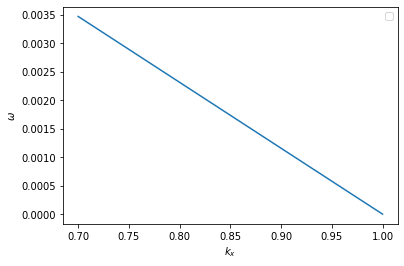

In [13]:
fig, ax = plt.subplots()

ax.plot(ks, freqs)
# ax.plot(ks, ks/clad_index, 'k-', linewidth=3, label='clad')
# ax.plot(ks, ks/core_index, '--', color='gray', linewidth=3, label='core')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$\omega$')
# ax.set_xlim([0,2])
# ax.set_ylim([0,1])
ax.legend()



In [21]:
f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
band_min = 1
band_max = 1 # Look at the two lowest modes
kdir = mp.Vector3(0,1)
tol = 1e-5
kmag_guess = 0.9
kmag_min = 0.6
kmag_max = 1

ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max)

E = ms.get_efield(1)


Initializing fields to random numbers...
Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 1 dimensions.
Grid size is 6000 x 1 x 1.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (60, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 60
Reciprocal lattice vectors (/ 2 pi):
     (0.0166667, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (0,0,0)
          size (10.4,0,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: .
1 k-points
  Vector3<0.0, 0.9, 0.0>
elapsed time for initialization: 0.014781713485717773
solve_kpoint (0,0.9,0):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1
Solving for bands 1 to 1...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.7693297638680261 (199.242% change)
    linmin: co

In [24]:
np.shape(E)

(6000, 1, 1, 3)

In [42]:
H = ms.get_hfield(1)

/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


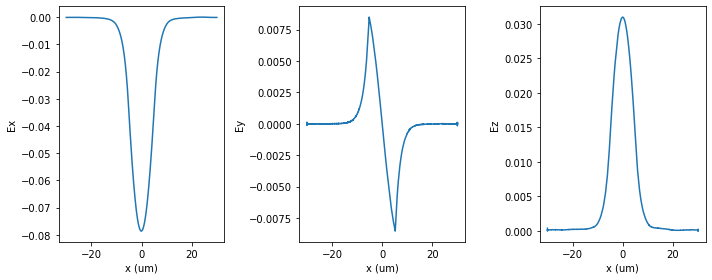

In [41]:
plt.figure(figsize=[10,4])

plt.subplot(1, 3, 1)
plt.plot(x, E[:,0,0,0])
plt.xlabel('x (um)')
plt.ylabel('Ex')

plt.subplot(1, 3, 2)
plt.plot(x, E[:,0,0,1])
plt.xlabel('x (um)')
plt.ylabel('Ey')

plt.subplot(1, 3, 3)
plt.plot(x, E[:,0,0,2])
plt.xlabel('x (um)')
plt.ylabel('Ez')

plt.tight_layout()

/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(-10, 0.02, '')

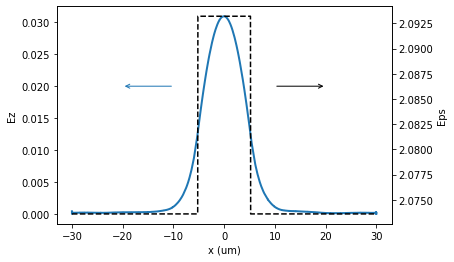

In [57]:
fig, ax1 = plt.subplots()

ax1.plot(x, E[:,0,0,2], linewidth=2)
ax1.set_xlabel('x (um)')
ax1.set_ylabel('Ez')

ax2 = ax1.twinx()
ax2.plot(x, eps, "k--")
ax2.set_ylabel('Eps')

ax1.annotate("", xy=(20, 0.02), xytext=(10, 0.02),

            arrowprops=dict(arrowstyle="->"))

ax1.annotate("", xy=(-20, 0.02), xytext=(-10, 0.02),

            arrowprops=dict(arrowstyle="->", color='tab:blue'))

/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/simbil/miniconda3/envs/pmp_mayavi/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


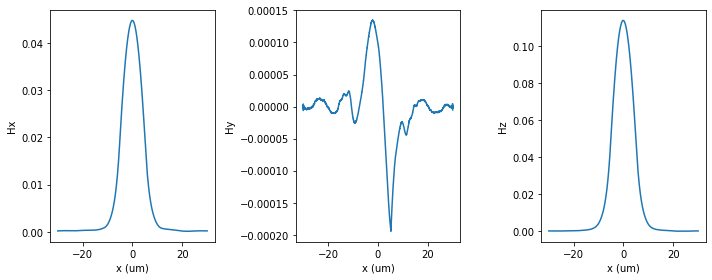

In [43]:
plt.figure(figsize=[10,4])

plt.subplot(1, 3, 1)
plt.plot(x, H[:,0,0,0])
plt.xlabel('x (um)')
plt.ylabel('Hx')

plt.subplot(1, 3, 2)
plt.plot(x, H[:,0,0,1])
plt.xlabel('x (um)')
plt.ylabel('Hy')

plt.subplot(1, 3, 3)
plt.plot(x, H[:,0,0,2])
plt.xlabel('x (um)')
plt.ylabel('Hz')

plt.tight_layout()